In [139]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from stop_words import get_stop_words
#from scipy import sparse
from scipy import spatial
import gensim
import utils
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import pickle
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from utils import random_idx
from utils import utils
from utils import lang_vectors_utils as lvu
from utils import documents
%matplotlib inline

num_topics = 50
passes = 20
#topn = 10
k = 5000
N = 10000
# cluster_sizes is mapping to n-gram size
# cluster_sz in random_idx referring to specific element (int) in cluster_sizes, array
cluster_sizes = [1, 2, 3, 4, 5, 6, 7, 8]
ordered = 1
#assuming this is the alphabet bc of precedent in generate_text.py
#alph = 'abc' 
alphabet = string.lowercase + ' '
RI_letters = random_idx.generate_letter_id_vectors(N, k, alphabet)
# words should be unique? (such as permutations)
# number of words added in a syntax vector
syntax_granularities = [5,10,100,200]
lower_n_cutoff = .85

In [140]:
def vectorize_documents(documents):
    vectors = {}
    for doc in documents:
        for word in doc:
            vectors[word] = random_idx.id_vector(N, word, alphabet, RI_letters)
    return vectors

def similarity_matrix(dictionary,id_to_word):
    """
    calculate cosine similarity of every word
    """
    num_words = len(id_to_word)
    sm = np.zeros((num_words,num_words))
    cutoff_index = int(lower_n_cutoff*num_words)
    syntax_cutoffs = np.zeros(num_words)

    for row in range(0,num_words):
        for col in range(0,num_words):
            sm[row][col] = np.dot(np.transpose(dictionary[id_to_word[row]][0]), dictionary[id_to_word[col]][0])
        # find the 85% smallest element in array
        syntax_cutoffs[row] = np.partition(sm[row], cutoff_index)[cutoff_index]
    return sm, syntax_cutoffs

def syntax_space(similarity_matrix, vectorized_dictionary, id_to_word, syntax_cutoffs):
    """
    number of granularities of words encoded per syntax vector x number of tokens x N
    index in numpy array on axis "number of tokens" equivalent to token id
    http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array
    """
    num_tokens = len(vectorized_dictionary.keys())
    print "num_tokens"
    matrices = np.zeros((len(syntax_granularities), num_tokens, N))
    print "made matrices"
    print matrices.shape
    for gran_i in range(len(syntax_granularities)):
        print gran_i
        for row in range(num_tokens):
            granularity = min(syntax_granularities[gran_i],num_tokens)
            for dot in similarity_matrix[row]:
                if dot >= syntax_cutoffs[row]:
                    matrices[gran_i][row] = np.add(matrices[gran_i][row],vectorized_dictionary[id_to_word[row]][0])
    return matrices

In [148]:
# run tests
"""
# actual shape is (4, 1848, 10000)
# supposed to be: (num_test_files, num_granularities) = (2,4)
"""
def accuracy_syntax(test_files, test_documents, id_to_word, vectorized_dictionary, syntaxed_space, syntax_cutoffs, syntax_granularities):
    accuracy_per_granularity = np.zeros((len(test_files),len(syntax_granularities)))
    for i in range(len(test_files)):
        test_tokens = test_documents[i]
        for gran_i in range(len(syntax_granularities)):
            for test_token in test_tokens:
                #number of granularities x number of tokens x N
                #N, dictionary[i], alphabet, RI_letters
                prediction_vector = np.dot(syntaxed_space[gran_i], np.transpose(random_idx.id_vector(N, test_token, alphabet, RI_letters)))
                #print prediction_vector.shape # should be (421,1)
                prediction_vector = np.transpose(prediction_vector)
                #print prediction_vector.shape # should be (421,1)
                prediction_id = np.argmax(prediction_vector[0])
 
                # account for new tokens and similarity not identity
                # >= bottom 85% cutoff for same vector group from similarity matrix
                if prediction_vector[0][prediction_id]/float(syntax_granularities[gran_i]) >= syntax_cutoffs[prediction_id]:
                    accuracy_per_granularity[i][gran_i]+=1
        accuracy_per_granularity[i] /= len(test_tokens)

    return accuracy_per_granularity


In [142]:
def graphing_3d():
    # each vector maps to the test_token. dots graphs but mappings can printed
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs =[1,2,3,4,5,6,7,8,9,10]
    ys =[5,6,2,3,13,4,1,2,4,8]
    zs =[2,3,3,3,5,7,9,11,9,10]

    xt =[-1,-2,-3,-4,-5,-6,-7,8,-9,-10]
    yt =[-5,-6,-2,-3,-13,-4,-1,2,-4,-8]
    zt =[-2,-3,-3,-3,-5,-7,9,-11,-9,-10]

    ax.scatter(xs, ys, zs, c='r', marker='o')
    ax.scatter(xt, yt, zt, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def graphing_2d(test_files, syntax_granularities, accuracy_per_granularity):
    for i in range(accuracy_per_granularity.shape[0]):
        print test_files[i]
        print len(syntax_granularities)
        print accuracy_per_granularity[i].shape
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(syntax_granularities, accuracy_per_granularity[i], c='r', marker='o')

        ax.set_xlabel('granularity')
        ax.set_ylabel('accuracy %')

        plt.show()

In [143]:
# create sample documents
raw_path = "raw_texts/texts_english/"
preprocessed_path = "preprocessed_texts/english/with_spaces/"
training_preprocessed_path = "preprocessed_texts/english/with_spaces/"

training_files = ["a_christmas_carol_mini.txt", "alice_in_wonderland_mini.txt"]
# this is for testing accuracy against the 
# actual stream that will be the test input
test_files = ["hamlet_english_mini.txt", "percy_addleshaw_mini.txt"]

In [144]:
training_doc_set = documents.create_doc_set(training_preprocessed_path, training_files)
test_doc_set = documents.create_doc_set(preprocessed_path, test_files)

training_documents = [doc.split() for doc in training_doc_set]
test_documents = [doc.split() for doc in test_doc_set]




In [97]:
vectorized_dictionary = vectorize_documents(training_documents)
id_to_word = {}
words = vectorized_dictionary.keys()
for i in range(len(words)):
    id_to_word[i] = words[i]
fwrite = open("vectorized_dictionary", "w")
fwrite1 = open("id_to_word", "w")
pickle.dump(vectorized_dictionary, fwrite)
pickle.dump(id_to_word, fwrite1)
fwrite.close()
fwrite1.close()

In [145]:
fread = open("vectorized_dictionary", "r")
fread1 = open("id_to_word", "r")
vectorized_dictionary = pickle.load(fread)
id_to_word = pickle.load(fread1)
fread.close()
fread1.close()
# similarity matrix
sm, syntax_cutoffs = similarity_matrix(vectorized_dictionary, id_to_word)
print sm
fwrite = open("sm", "w")
fwrite1 = open("syntax_cutoffs", "w")
pickle.dump(sm, fwrite)
pickle.dump(syntax_cutoffs, fwrite1)
fwrite.close()
fwrite1.close()

[[ 10000.    -16.    124. ...,   -100.     60.    156.]
 [   -16.  10000.    -44. ...,    -88.     24.    -24.]
 [   124.    -44.  10000. ...,    136.     96.     60.]
 ..., 
 [  -100.    -88.    136. ...,  10000.     60.    -52.]
 [    60.     24.     96. ...,     60.  10000.    164.]
 [   156.    -24.     60. ...,    -52.    164.  10000.]]


In [146]:
fread = open("vectorized_dictionary", "r")
fread1 = open("id_to_word", "r")
fread2 = open("sm", "r")
fread3 = open("syntax_cutoffs", "r")
vectorized_dictionary = pickle.load(fread)
id_to_word = pickle.load(fread1)
sm = pickle.load(fread2)
syntax_cutoffs = pickle.load(fread3)
fread.close()
fread1.close()
fread2.close()
fread3.close()

syntaxed_space = syntax_space(sm, vectorized_dictionary, id_to_word, syntax_cutoffs)
fwrite = open("syntaxed_space", "w")
pickle.dump(syntaxed_space, fwrite)
fwrite.close()

num_tokens
made matrices
(4, 421, 10000)
0
1
2
3


(2, 4)
hamlet_english_mini.txt
4
(4,)


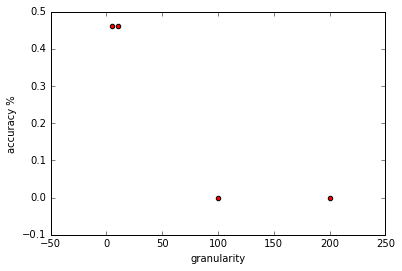

percy_addleshaw_mini.txt
4
(4,)


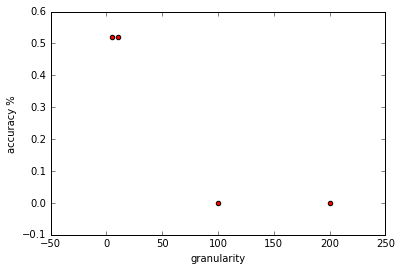

In [152]:
# since humza is already doing the syntax space I want (in his case the meaning space)
# my syntax space isn't that necessary for tenses, but mainly words that look similar.
# another way to test for bias. another way for syntax?
fread = open("sm", "r")
fread1 = open("syntax_cutoffs", "r")
fread2 = open("vectorized_dictionary", "r")
fread3 = open("id_to_word", "r")
fread4 = open("syntaxed_space", "r")
sm = pickle.load(fread)
syntax_cutoffs = pickle.load(fread1)
vectorized_dictionary = pickle.load(fread2)
id_to_word = pickle.load(fread3)
syntaxed_space = pickle.load(fread4)
fread.close()
fread1.close()
fread2.close()
fread3.close()
fread4.close()
accuracy_per_granularity = accuracy_syntax(test_files, test_documents, id_to_word, vectorized_dictionary, syntaxed_space, syntax_cutoffs*100, syntax_granularities)
print accuracy_per_granularity.shape
fwrite = open("accuracy_per_granularity","w")
pickle.dump(syntaxed_space, fwrite)
fwrite.close()
graphing_2d(test_files, syntax_granularities, accuracy_per_granularity)